In [1]:
#　ライブラリのインポート
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.stats import norm, skew

%matplotlib inline 

In [2]:
# # trainデータ
train = pd.read_csv('./data/train.csv')
# # testデータ
test = pd.read_csv('./data/test.csv')

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
df = pd.DataFrame(train)
df = df.fillna(df.mean())

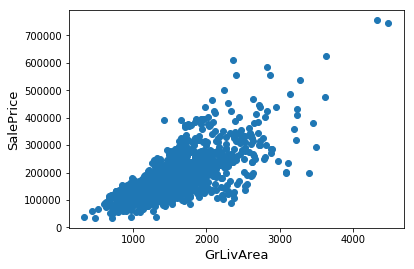

In [5]:
# ノイズの削除
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 12.02 and sigma = 0.40



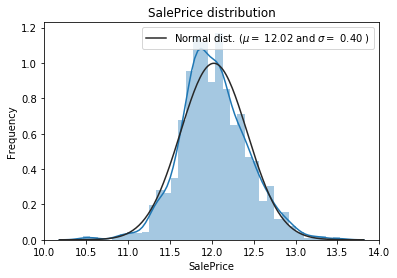

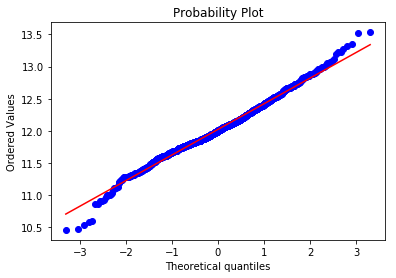

In [6]:
# 正規分布へ
df["SalePrice"] = np.log1p(df["SalePrice"])
sns.distplot(df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()

In [7]:
X = df.loc[:, ['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'TotalBsmtSF']].values
y = df.loc[:, ['SalePrice']].values

In [8]:
# 標準化
ss = StandardScaler()
X = ss.fit_transform(X)

In [9]:
# 多項式化
from sklearn.preprocessing import PolynomialFeatures
quad = PolynomialFeatures(degree=2)
X = quad.fit_transform(X)

In [10]:
# ホールド・アウト
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [11]:
# Ridge回帰のクラスを読み込み
from sklearn.linear_model import Ridge
# GridSearchでハイパーパラメータを探す旅
from sklearn.model_selection import GridSearchCV
param_grid = { 'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000 ] }
model_ridge = GridSearchCV(
    estimator=Ridge(random_state=0),
    param_grid=param_grid
)
# データを学習させる
model_ridge.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=0,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500,
                                   1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
def adjusted(score, n_sample, n_features):
    adjusted_score = 1 - (1 - score) * ((n_sample - 1) / (n_sample - n_features - 1))
    return adjusted_score

In [13]:
# モデルの評価
print(model_ridge.best_params_)
print('adjusted R^2')
print('train: %.3f' % adjusted(model_ridge.score(X_train, y_train), len(y_train),X_train.shape[1]))
print('test : %.3f' % adjusted(model_ridge.score(X_test, y_test), len(y_test), X_test.shape[1]))

{'alpha': 50}
adjusted R^2
train: 0.840
test : 0.870


In [14]:
#  Lasso回帰
from sklearn.linear_model import Lasso
param_grid = { 'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000 ] }
model_lasso = GridSearchCV(
    estimator=Lasso(random_state=0),
    param_grid=param_grid
)
model_lasso.fit(X_train, y_train)

# モデルの評価
print(model_lasso.best_params_)
print('R^2')
print('train: %.3f' % adjusted(model_lasso.score(X_train, y_train), len(y_train),X_train.shape[1]))
print('test : %.3f' % adjusted(model_lasso.score(X_test, y_test), len(y_test), X_test.shape[1]))

{'alpha': 0.01}
R^2
train: 0.833
test : 0.867


In [15]:

# ElasticNetを使用
from sklearn.linear_model import ElasticNet
param_grid = { 'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000 ], 'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] }
model_en = GridSearchCV(
    estimator=ElasticNet(random_state=0),
    param_grid=param_grid
)
model_en.fit(X_train, y_train)

# モデルの評価
print(model_lasso.best_params_)
print('R^2')
print('train: %.3f' % adjusted(model_en.score(X_train, y_train), len(y_train),X_train.shape[1]))
print('test : %.3f' % adjusted(model_en.score(X_test, y_test), len(y_test), X_test.shape[1]))


{'alpha': 0.01}
R^2
train: 0.839
test : 0.870


In [16]:
# 線形回帰を使用
from sklearn.linear_model import LinearRegression
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)

# モデルの評価
print('adjusted R^2')
print('train: %.3f' % adjusted(model_lin.score(X_train, y_train), len(y_train),X_train.shape[1]))
print('test : %.3f' % adjusted(model_lin.score(X_test, y_test), len(y_test), X_test.shape[1]))

adjusted R^2
train: 0.841
test : 0.870


In [17]:
# 残差プロットを行う関数を定義
def res_plot(y_train, y_train_pred, y_test, y_test_pred):
    # train, testごとに残差を算出
    res_train = y_train_pred - y_train
    res_test  = y_test_pred - y_test
    
    # train, testごとに(予測値, 残差)をプロット
    plt.scatter(y_train_pred, res_train, color='blue', marker='o', label='train', alpha=1)
    plt.scatter(y_test_pred, res_test, color='green', marker='s', label='test', alpha=1)
    
    # x軸のラベルを表示
    plt.xlabel('Predicted Values')
    # y軸のラベルを表示
    plt.ylabel('Residuals')
    # 凡例を左上に表示
    plt.legend(loc='upper left')
    # 残差0の線を表示
    plt.hlines(y=0, xmin=-10, xmax=500000, color='red')
    # 上記の内容でグラフを表示
    plt.show()

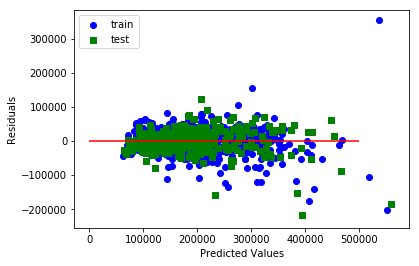

In [15]:
res_plot(y_train, model_ridge.predict(X_train), y_test, model_ridge.predict(X_test))

In [18]:
df_test = pd.DataFrame(test)
df_test = df_test.fillna(df_test.mean())

In [19]:
# # testデータの欠損値を補完する
# df_test.loc[:, ['GarageCars']] = df_test.loc[:, ['GarageCars']].fillna(df_test.loc[:, ['GarageCars']].mean())

In [20]:
X_test = df_test.loc[:, ['OverallQual', 'GrLivArea', 'GarageCars', 'YearBuilt', 'TotalBsmtSF']].values
X_test = ss.fit_transform(X_test)
# 多項式化
from sklearn.preprocessing import PolynomialFeatures
quad = PolynomialFeatures(degree=2)
X_test = quad.fit_transform(X_test)

In [21]:
y_pred_lin = model_lin.predict(X_test).reshape(-1)
y_pred_ridge = model_ridge.predict(X_test).reshape(-1)
y_pred_lasso = model_lasso.predict(X_test)
y_pred_en = model_en.predict(X_test)

In [22]:
y_pred = (y_pred_lin + y_pred_ridge + y_pred_lasso + y_pred_en) / 4
print(y_pred, y_pred.shape, type(y_pred))

[11.66548696 11.96409851 12.04481953 ... 11.88795131 11.65822695
 12.39484229] (1459,) <class 'numpy.ndarray'>


In [23]:
y_pred = np.exp(y_pred)
print(y_pred, y_pred.shape, type(y_pred))

[116481.40888876 157015.29695731 170215.32441578 ... 145502.90244226
 115638.8155797  241552.54071394] (1459,) <class 'numpy.ndarray'>


In [108]:
# y_pred = y_pred.flatten()
# print(y_pred, y_pred.shape, type(y_pred))

[117356.0951861  163121.7928617  169329.81299141 ... 151197.68415594
 115505.07479103 254842.86889503] (1459,) <class 'numpy.ndarray'>


In [24]:
test['SalePrice'] = y_pred
test[['Id','SalePrice']].to_csv('./data/submission.csv',index=False)